In [1]:
import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util
import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 32

params = {
    'context_count' : 16,
    'k' : 8,
    'attr_func' : attr_util.discrete_pareto_val, # attribute assignment function
    'edge_util_func' : attr_util.total_inv_frequency,
    'edge_prob_func' : attr_util.marginal_logistic,
    'edge_selection' : attr_util.greedy_simul_edge_calc,
    'direct_cost' : 20,
    'indirect_cost' : 0
}

In [3]:
def graph_density(G):
    denum = (G.num_people * (G.num_people - 1))
    num = sum([ v.degree for v in G.vertices])
    return num / denum

def second_eigv(G):
    G_nx = gnx.graph_to_nx(G)
    laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
    eigvals = scp_sla.eigs(laplacian, return_eigenvectors=False)
    eigvals.sort()
    return eigvals[1]

def social_welfare(G):
    return sum([ v.data for v in G.vertices ]) / 2

In [4]:
def print_metrics(G):
    gd = graph_density(G)
    eig2 = second_eigv(G)
    sw = social_welfare(G)
    
    print("""Graph density: {0}, \
    second eigenvalue: {1}, \
    social welfare: {2}""".format(gd, eig2, sw))

Graph density: 0.2056451612903226,     second eigenvalue: (1.470205114087191+0j),     social welfare: 824.9612165612165
Graph density: 0.23387096774193547,     second eigenvalue: (1.4291705688230378+0j),     social welfare: 1023.3740684605672


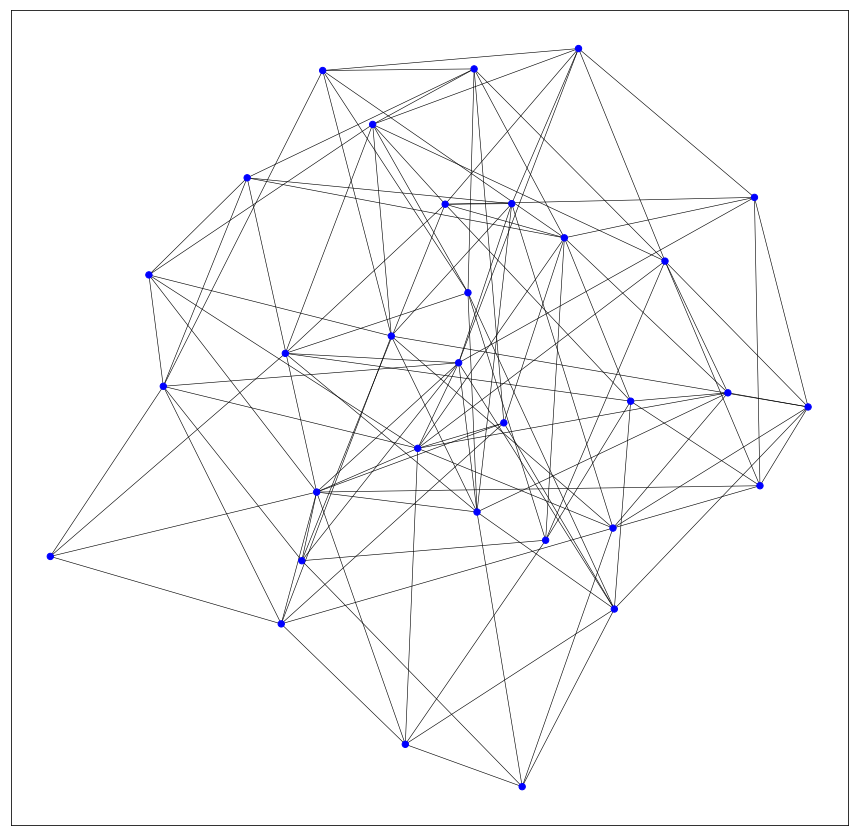

In [5]:
G = attribute_network(_N, params)

print_metrics(G)

random_walk(G)
calc_utils(G)
calc_edges(G)

print_metrics(G)
        
#print(list(zip([ v.vnum for v in G.vertices], 
#               [ attr_util.remaining_budget(v, G) for v in G.vertices ],
#               [ v.degree for v in G.vertices ])))

vis.draw_graph(G)